### CNN architecture 
cnn is based on 2 techniques 
- **Convolution**: where applying some types of filters on the images to extract new higher features like vertical edges, horizontal edges, texture instead of looking at every pixel in the image.
- **Pooling**: this another technique used by the CNN to compress the output from layers without losing the main features of the input like "vertical feats". There is avg/max pooling.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the data
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labesl), (test_images, test_labels) = mnist.load_data()

# explore the data
print(train_images.shape)
print(train_labesl.shape)

# preprocess the data and prepare it for training the model.
m, h, w = train_images.shape
train_images = train_images.reshape(m, h, w, 1) / 255.0
m, h, w = test_images.shape
test_images = test_images.reshape(m, h, w, 1) / 255.0

(60000, 28, 28)
(60000,)


In [4]:
# define your model (cnn model)
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=(h, w, 1)),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPool2D(2, 2)
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# compile the model by setting the optimizer, loss and the metrics.
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model.
class Accuracy_90(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print(f"\nReached 90% accuracy so cancelling training in epoch {epoch}!")
      self.model.stop_training = True
        
model.fit(train_images, train_labesl, epochs=5, callbacks=[])

# evaluate the model
print("Evaluation")
model.evaluate(test_images, test_labels)

# print the summery about the models (no of layers, no of parameters)
model.summary()

Epoch 1/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.5739 - accuracy: 0.7903
Epoch 2/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.3837 - accuracy: 0.8590
Epoch 3/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3252 - accuracy: 0.8795
Epoch 4/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2914 - accuracy: 0.8913
Epoch 5/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2659 - accuracy: 0.9011
Evaluation
313/313 [==============================] - 2s 7ms/step - loss: 0.3222 - accuracy: 0.8784
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________

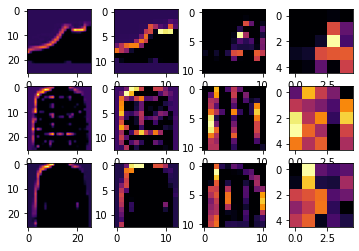

In [101]:
# visualize the learning features using CNN
# visualize the convloution output of the first 4 layers for 3 different  images.
Images = [0, 7, 26]
CONVOLUTION_NUM = 1

# figure subplots.
f, axarr = plt.subplots(3,4)

# construct the activation model from the existing one.
layers_output = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layers_output)

for im in range(len(Images)):
    layers_out = activation_model.predict(test_images[Images[im]].reshape(1, 28, 28, 1))
    for ly in range(0, 4):
        layer_out = layers_out[ly]
        axarr[im, ly].imshow(layer_out[0, : , :, CONVOLUTION_NUM], cmap='inferno')
        axarr[im,ly].grid(False)
    

**Note** as you can see the previous visualization the CONV layer output is more robust and has clear pattern for the object more than the output of the second one. So your model did well on the training and testing when you remove the second layer.

#### Whole-model saving
You can save an entire model to a single artifact. It will include:

- The model's architecture/config
- The model's weight values (which were learned during training)
- The model's compilation information (if compile()) was called
- The optimizer and its state, if any (this enables you to restart training where you left)

The model architecture, and training configuration (including the optimizer, losses, and metrics) are stored in saved_model.pb. The weights are saved in the variables/ directory.

[look here for more info](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [15]:
# save the model
model_path = "fashion_Mnist_cnn"

# save as H5 format
model.save(model_path+"/model.h5", save_format='h5')

# save as tensorflow savedModel format (.pb, variables, assests)
model.save(model_path)

INFO:tensorflow:Assets written to: fashion_Mnist_cnn/assets


In [16]:
# load the model to continue training or to use it for prediction
saved_model = keras.models.load_model(model_path)

In [20]:
test_image = test_images[0].reshape(1, 28, 28, 1)

# CHECK NO CORRUPTION HAPPENED WHEN W/R THE MODEL.
np.testing.assert_allclose(
    model.predict(test_image), saved_model.predict(test_image)
)